In [4]:
### Load necessary modules -------------------------------
# interactive plotting
%matplotlib inline
%config InlineBackend.figure_format = 'svg' # ‘png’, ‘retina’, ‘jpeg’, ‘svg’, ‘pdf’

# plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

# Data management libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Machine learning libraries
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix as sk_confusion_matrix
from xgboost import XGBClassifier
import joblib

# others
from funciones_limpieza import *
from utils_aprendizaje_no_supervisado import *
from funciones_clasificacion import *
from funciones_seriestemporales import *

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/MyDrive/RandomForest')

In [3]:

pip install neuralsens

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 kB 4.6 MB/s eta 0:00:00


In [5]:
#Calcular métricas a partir de matriz acumulada
def resumen_metricas_desde_cm(cm):
    TP = cm[1, 1]
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]

    total = TP + TN + FP + FN
    acc = (TP + TN) / total
    sens = TP / (TP + FN) if (TP + FN) != 0 else 0
    spec = TN / (TN + FP) if (TN + FP) != 0 else 0
    prec = TP / (TP + FP) if (TP + FP) != 0 else 0
    recall = sens
    f1 = 2 * (prec * recall) / (prec + recall) if (prec + recall) != 0 else 0
    bal_acc = (sens + spec) / 2

    print(f"Accuracy: {acc:.2f}")
    print(f"Recall (Sensitivity): {recall:.2f}")
    print(f"Specificity: {spec:.2f}")
    print(f"Precision: {prec:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"Balanced Accuracy: {bal_acc:.2f}") #A diferencia del accuracy tradicional, que puede ser engañosamente alto si una clase domina, la balanced accuracy da un peso igual a cada clase, evaluando el desempeño del modelo en cada una por separado y luego promediando.

In [6]:
!nvidia-smi


Thu Jun 12 11:19:01 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   38C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Carga de los csvs y preprocesado

In [7]:
# ---------------------
# 1. Definir carpetas
# ---------------------
carpeta_myrtle = "./Join_plots_alarmas"
carpeta_sigma = "./Join_plots_alarmas_Sigma"

# ---------------------
# 2. Obtener lista de CSVs
# ---------------------
archivos = []
for carpeta in [carpeta_myrtle, carpeta_sigma]:
    archivos += [os.path.join(carpeta, f) for f in os.listdir(carpeta) if f.endswith(".csv")]

print(f"Total de archivos (inversores): {len(archivos)}")

# ---------------------
# 3. Leer y unir todos
# ---------------------
dfs_global = []
for f in archivos:
    nombre_inversor = os.path.splitext(os.path.basename(f))[0]  # sin extensión
    df = pd.read_csv(f)
    df['FechaHora'] = pd.to_datetime(df['FechaHora'])
    df['inversor_id'] = nombre_inversor
    df['Condensacion'] = df['Condensacion'].astype('category')
    dfs_global.append(df)

df_global = pd.concat(dfs_global, ignore_index=True)

print(f"Shape del DataFrame global: {df_global.shape}")
print(df_global[['inversor_id']].value_counts())  # Ver cuantos registros por inversor


Total de archivos (inversores): 72
Shape del DataFrame global: (3110328, 47)
inversor_id 
10.144.51.1     86398
10.144.51.15    86398
10.144.51.11    43199
10.144.51.12    43199
10.144.51.13    43199
                ...  
10.144.51.72    43199
10.144.51.73    43199
10.144.51.8     43199
10.144.51.9     43199
F1              43199
Name: count, Length: 70, dtype: int64


In [8]:
# Define input and output matrices
variables = df_global.columns.to_list()
INPUTS = [var for var in variables if var != 'Condensacion']
OUTPUT = 'Condensacion'
X = df_global[INPUTS]
y = df_global[OUTPUT]

In [9]:
y_inversores = [] #será una lista de tamaño 72 cada elemento será 1 o 0 dependiendo del valor que tenga la columna 'Condensación'

for f in archivos:
    df = pd.read_csv(f)
    if df['Condensacion'].unique() == 1:
        y_inversores.append(1)
    else:
        y_inversores.append(0)

In [10]:
# ---------------------
# División en train y test por inversor
# ---------------------
archivos_train, archivos_test = train_test_split(archivos,
                                                 test_size=0.2,
                                                 random_state=42,
                                                 stratify = y_inversores) #preserva la distribución de y (proporción de 1 y 0)

dfs_train = []
for f in archivos_train:
    nombre_inversor = os.path.splitext(os.path.basename(f))[0]  # sin extensión
    df = pd.read_csv(f)
    df['FechaHora'] = pd.to_datetime(df['FechaHora'])
    df['inversor_id'] = nombre_inversor
    dfs_train.append(df)

dfs_test = []
for f in archivos_test:
    nombre_inversor = os.path.splitext(os.path.basename(f))[0]  # sin extensión
    df = pd.read_csv(f)
    df['FechaHora'] = pd.to_datetime(df['FechaHora'])
    df['inversor_id'] = nombre_inversor
    dfs_test.append(df)

df_train_total = pd.concat(dfs_train, ignore_index=True)
df_test_total = pd.concat(dfs_test, ignore_index=True)

print("Inversores en train:", len(dfs_train))
print("Inversores en test:", len(dfs_test))
print("Shape train:", df_train_total.shape)
print("Shape test:", df_test_total.shape)

Inversores en train: 57
Inversores en test: 15
Shape train: (2462343, 47)
Shape test: (647985, 47)


In [11]:
#Localizamos los inversores con fallo de condensación tanto en train como test
condensacion_test = []
for archivo in archivos_test:
    nombre_inversor = os.path.splitext(os.path.basename(archivo))[0]
    df_inv = df_test_total[df_test_total['inversor_id'] == nombre_inversor]
    if 1 in df_inv['Condensacion'].values:
        condensacion_test.append(df_inv)
        print(f'El inversor {nombre_inversor} de test ha tenido fallo de condensación')

condensacion_train = []
for archivo in archivos_train:
    nombre_inversor = os.path.splitext(os.path.basename(archivo))[0]
    df_inv = df_train_total[df_train_total['inversor_id'] == nombre_inversor]
    if 1 in df_inv['Condensacion'].values:
        condensacion_train.append(df_inv)
        print(f'El inversor {nombre_inversor} de train ha tenido fallo de condensación')

El inversor 10.144.51.29 de test ha tenido fallo de condensación
El inversor 10.144.51.56 de train ha tenido fallo de condensación
El inversor 10.144.51.1 de train ha tenido fallo de condensación
El inversor 10.144.51.15 de train ha tenido fallo de condensación
El inversor 10.144.51.15 de train ha tenido fallo de condensación
El inversor 10.144.51.1 de train ha tenido fallo de condensación
El inversor 10.144.51.51 de train ha tenido fallo de condensación
El inversor F1 de train ha tenido fallo de condensación


In [12]:
X_train = df_train_total[INPUTS]
y_train = df_train_total[OUTPUT]
X_test = df_test_total[INPUTS]
y_test = df_test_total[OUTPUT]

# XGBoost con variables ['T_SKIIP_MIN', 'TPOT_CAB_MAX', 'T_LIQ_MIN', 'DELTA_TEMP_AMB']

In [13]:
## Create dataset to store model predictions
dfTR_eval = X_train.copy()
dfTR_eval['Y'] = y_train # We will call Y as output variable for simplicity
dfTS_eval = X_test.copy()
dfTS_eval['Y'] = y_test # We will call Y as output variable for simplicity

In [ ]:
#-------------------------------------------------------------------------------------------------
#---------------------------- XGBOOST MODEL ------------------------------------------------
#-------------------------------------------------------------------------------------------------
## Inputs of the model. Change accordingly to perform variable selection

scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

INPUTS_XGB = ['T_SKIIP_MIN', 'TPOT_CAB_MAX', 'T_LIQ_MIN', 'DELTA_TEMP_AMB']

# Grid de parámetros
param_grid = {
    'xgb__n_estimators': [100, 200], #Número total de árboles (estimadores) que se construyen. Más árboles suelen mejorar el rendimiento pero aumentan el tiempo de entrenamiento y riesgo de overfitting.
    'xgb__max_depth': [3, 5, 7], #Profundidad máxima permitida para cada árbol. Controla la complejidad del árbol.
    'xgb__learning_rate': [0.01, 0.1], #Paso de actualización en cada iteración. Controla cuánto aporta cada árbol.
                                       #Valores bajos hacen el entrenamiento más lento pero a veces mejor generalización.
                                       #Valores altos hacen que aprenda rápido, pero puede sobreajustar.
    'xgb__subsample': [0.8, 1.0], #Proporción de muestras usadas para construir cada árbol (bootstrap sampling). Reduce sobreajuste al usar sólo parte de los datos para cada árbol.
    'xgb__colsample_bytree': [0.8, 1.0] #Proporción de características (columnas) usadas para construir cada árbol. Similar a Random Forest que usa una muestra aleatoria de columnas para diversificar los árboles.
}

# El árbol no realizará una partición en un nodo interno a menos que la reducción en la impureza sea al menos tan grande como este valor.
#Esto significa que para que una partición ocurra en un nodo, la mejora en la entropía debe ser al menos del 2%.
#param = {'DT__min_impurity_decrease': [0.02]} # Minimum entropy to decrease in each split
pipe = Pipeline([('scaler', StandardScaler()),
                 ('xgb', XGBClassifier(scale_pos_weight=scale_pos_weight,
                                       tree_method='gpu_hist', #Método de construcción del árbol optimizado para GPU, muy rápido para datasets grandes.
                                       predictor='gpu_predictor', #Indica que las predicciones también se harán usando GPU.
                                       eval_metric='logloss', #Métrica usada para evaluar el error durante el entrenamiento (log loss es la pérdida logarítmica para clasificación)
                                       use_label_encoder=False, #Evita una advertencia por usar un codificador de etiquetas interno que ahora está obsoleto
                                       random_state=150))])



# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined
nFolds = 10
# Grid Search con validación cruzada
xgb_fit = GridSearchCV(estimator=pipe,
                       param_grid=param_grid,
                       scoring='recall',
                       cv=nFolds,
                       verbose=1,
                       n_jobs=-1)

xgb_fit.fit(X_train[INPUTS_XGB], y_train) # Search in grid

In [ ]:
#Guardamos en Drive el grid search
#joblib.dump(xgb_fit, '/content/drive/MyDrive/RandomForest/xgb4_fit_gridsearch.pkl')
#xgb_fit = joblib.load('/content/drive/MyDrive/RandomForest/xgb4_fit_gridsearch.pkl')


#Guardamos los mejores parámetros
#best_params = xgb_fit.best_params_
#joblib.dump(best_params, '/content/drive/MyDrive/RandomForest/best_params.pkl')
#Para cargar los parámetros
best_params = joblib.load('/content/drive/MyDrive/RandomForest/best_params.pkl')
#pipe.set_params(**best_params)
#pipe.fit(X_train, y_train)

In [15]:
mejores_parametros = {
    'xgb__colsample_bytree': [0.8],
    'xgb__learning_rate': [0.1],
    'xgb__max_depth': [5],
    'xgb__n_estimators': [200],
    'xgb__subsample': [1.0]
}
#xgb_fit.best_params_

In [ ]:
best_params

NameError: name 'best_params' is not defined

In [16]:
#-------------------------------------------------------------------------------------------------
#---------------------------- XGBOOST MODEL ------------------------------------------------
#-------------------------------------------------------------------------------------------------
## Inputs of the model. Change accordingly to perform variable selection

scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

INPUTS_XGB = ['T_SKIIP_MIN', 'TPOT_CAB_MAX', 'T_LIQ_MIN', 'DELTA_TEMP_AMB']

# Grid de parámetros
#param_grid = {
#    'xgb__n_estimators': [100, 200], #Número total de árboles (estimadores) que se construyen. Más árboles suelen mejorar el rendimiento pero aumentan el tiempo de entrenamiento y riesgo de overfitting.
#    'xgb__max_depth': [3, 5, 7], #Profundidad máxima permitida para cada árbol. Controla la complejidad del árbol.
#    'xgb__learning_rate': [0.01, 0.1], #Paso de actualización en cada iteración. Controla cuánto aporta cada árbol.
                                       #Valores bajos hacen el entrenamiento más lento pero a veces mejor generalización.
                                       #Valores altos hacen que aprenda rápido, pero puede sobreajustar.
#    'xgb__subsample': [0.8, 1.0], #Proporción de muestras usadas para construir cada árbol (bootstrap sampling). Reduce sobreajuste al usar sólo parte de los datos para cada árbol.
#    'xgb__colsample_bytree': [0.8, 1.0] #Proporción de características (columnas) usadas para construir cada árbol. Similar a Random Forest que usa una muestra aleatoria de columnas para diversificar los árboles.
#}

# El árbol no realizará una partición en un nodo interno a menos que la reducción en la impureza sea al menos tan grande como este valor.
#Esto significa que para que una partición ocurra en un nodo, la mejora en la entropía debe ser al menos del 2%.
param_grid = mejores_parametros
pipe = Pipeline([('scaler', StandardScaler()),
                 ('xgb', XGBClassifier(scale_pos_weight=scale_pos_weight,
                                       tree_method='gpu_hist', #Método de construcción del árbol optimizado para GPU, muy rápido para datasets grandes.
                                       predictor='gpu_predictor', #Indica que las predicciones también se harán usando GPU.
                                       eval_metric='logloss', #Métrica usada para evaluar el error durante el entrenamiento (log loss es la pérdida logarítmica para clasificación)
                                       use_label_encoder=False, #Evita una advertencia por usar un codificador de etiquetas interno que ahora está obsoleto
                                       random_state=150))])



# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined
nFolds = 10
# Grid Search con validación cruzada
xgb_fit = GridSearchCV(estimator=pipe,
                       param_grid=param_grid,
                       scoring='recall',
                       cv=nFolds,
                       verbose=1,
                       n_jobs=-1)

xgb_fit.fit(X_train[INPUTS_XGB], y_train) # Search in grid

Fitting 10 folds for each of 1 candidates, totalling 10 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:32:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:32:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('xgb',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric='logloss',
                                                      feature_types=None,
                                                      gamma=None,
                                                      grow_policy=None,
                                                      importance_t...
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor='gpu_predictor', ...))]),
             n_jobs=-1,
             param_grid={'xgb__colsample_bytree': [0.8],
                         'xgb__learning_rate': [0.1], 'xgb__max_depth': [5],
                         'xgb__n_estimators': [200], 'xgb__subsample': [1.0]},
             scoring='recall', verbose=1)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:33:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


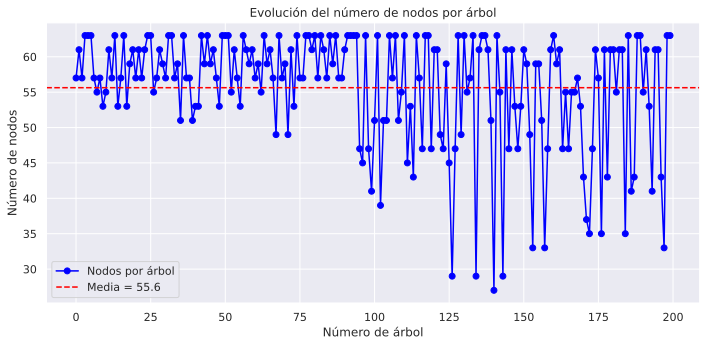

In [ ]:
#NÚMERO DE NODOS

booster = xgb_fit.best_estimator_['xgb'].get_booster()

# Obtener DataFrame con todos los árboles
trees_df = booster.trees_to_dataframe()

# Número total de árboles
num_trees = booster.num_boosted_rounds()

# Contar número de nodos por árbol
nodes_per_tree = [
    len(trees_df[trees_df['Tree'] == tree_id])
    for tree_id in range(num_trees)
]

# Calcular la media
mean_nodes = np.mean(nodes_per_tree)

# Graficar
plt.figure(figsize=(10, 5))
plt.plot(range(num_trees), nodes_per_tree, marker='o', label='Nodos por árbol', color='blue')
plt.axhline(mean_nodes, color='red', linestyle='--', label=f'Media = {mean_nodes:.1f}')
plt.xlabel('Número de árbol')
plt.ylabel('Número de nodos')
plt.title('Evolución del número de nodos por árbol')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/RandomForest/XGBoost4_NumeroNodosArbol.png')
plt.show()


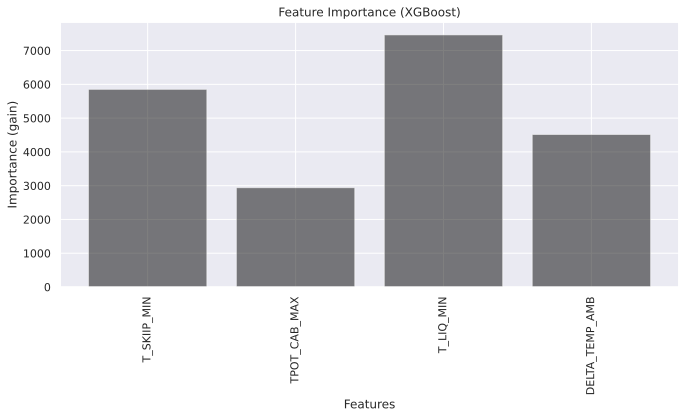

In [ ]:
#IMPORTANCIA DE VARIABLES

# Mapping manual de 'f0', 'f1', ... a nombres reales
raw_importance = booster.get_score(importance_type='gain')

# Ordenar por índice f0, f1, ..., convertir a números
sorted_keys = sorted(raw_importance.keys(), key=lambda x: int(x[1:]))
importances = [raw_importance.get(f, 0) for f in sorted_keys]

# Mapear a nombres reales
feature_names = X_train[INPUTS_XGB].columns.tolist()
feature_names = feature_names[:len(importances)]  # por seguridad

# Graficar
plt.figure(figsize=(6 * 1.618, 6))
index = np.arange(len(importances))
plt.bar(index, importances, color='black', alpha=0.5)
plt.xlabel('Features')
plt.ylabel('Importance (gain)')
plt.title('Feature Importance (XGBoost)')
plt.xticks(index, feature_names, rotation=90)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/RandomForest/XGBoost4_ImportanciaVariables.png')
plt.show()


In [17]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['Y_XGB_pred'] = xgb_fit.predict(X_train[INPUTS_XGB])
dfTR_eval['Y_XBG_prob_neg'] = xgb_fit.predict_proba(X_train[INPUTS_XGB])[:,0]
dfTR_eval['Y_XGB_prob_pos'] = xgb_fit.predict_proba(X_train[INPUTS_XGB])[:,1]
### Scale test using preprocess in training
dfTS_eval['Y_XGB_pred'] = xgb_fit.predict(X_test[INPUTS_XGB])
dfTS_eval['Y_XGB_prob_neg'] = xgb_fit.predict_proba(X_test[INPUTS_XGB])[:,0]
dfTS_eval['Y_XGB_prob_pos'] = xgb_fit.predict_proba(X_test[INPUTS_XGB])[:,1]

#visualize evaluated data (TRAIN)
dfTR_eval.head()

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:32:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:32:30] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


FechaHora         utc   sample    PPC_PMG   PPC_QMG        PMG_M  \
0 2025-03-04 17:02:24  1741107744  1126409  2382000.0 -194000.0  2069264.250   
1 2025-03-04 17:02:26  1741107746  1126410  2382000.0 -194000.0  2070086.125   
2 2025-03-04 17:02:28  1741107748  1126411  2382000.0 -194000.0  2070653.625   
3 2025-03-04 17:02:30  1741107750  1126412  2382000.0 -194000.0  2073132.125   
4 2025-03-04 17:02:32  1741107752  1126413  2382000.0 -194000.0  2071505.375   

           QMG_M     UL1_RMS     UL2_RMS     UL3_RMS  ...  DPF_TEMP_INT  \
0 -193998.937500  392.325562  395.115509  392.252441  ...           0.0   
1 -194270.625000  393.492859  394.579132  391.709167  ...           0.0   
2 -194212.203125  393.434326  394.454315  391.595551  ...           0.0   
3 -194025.578125  393.475494  394.583221  391.690735  ...           0.0   
4 -194103.296875  393.611450  394.674927  391.807343  ...           0.0   

   T_SKIIP_MIN  TPOT_CAB_MAX  T_LIQ_MIN  DELTA_TEMP_AMB   inversor_id  Y  \
0    49.368938     38.185669  46.522331       11.183269  10.144.51.11  0   
1    49.436443     38.185669  46.522331       11.250774  10.144.51.11  0   
2    49.490562     38.185654  46.522331       11.304908  10.144.51.11  0   
3    49.340439     37.843929  46.522331       11.496510  10.144.51.11  0   
4    49.412216     38.185654  46.522331       11.226562  10.144.51.11  0   

   Y_XGB_pred  Y_XBG_prob_neg  Y_XGB_prob_pos  
0           0        0.980711        0.019289  
1           0        0.980711        0.019289  
2           0        0.980711        0.019289  
3           0        0.966114        0.033886  
4           0        0.980711        0.019289  

[5 rows x 50 columns]

In [ ]:
#visualize evaluated data (TEST)
dfTS_eval.head()

FechaHora         utc   sample    PPC_PMG   PPC_QMG        PMG_M  \
0 2025-03-04 17:20:17  1741108817  1469199  1767000.0 -190000.0  1442545.875   
1 2025-03-04 17:20:19  1741108819  1469200  1767000.0 -190000.0  1439098.000   
2 2025-03-04 17:20:21  1741108821  1469201  1761000.0 -190000.0  1439510.875   
3 2025-03-04 17:20:23  1741108823  1469202  1761000.0 -190000.0  1438081.000   
4 2025-03-04 17:20:25  1741108825  1469203  1761000.0 -190000.0  1436976.250   

           QMG_M     UL1_RMS     UL2_RMS     UL3_RMS  ...  DPF_TEMP_INT  \
0 -189878.218750  393.132935  394.774139  393.665833  ...           0.0   
1 -189953.687500  394.431305  394.275208  393.117096  ...           0.0   
2 -190008.562500  394.286591  394.106476  393.035156  ...           0.0   
3 -190265.765625  393.133331  394.725250  393.739685  ...           0.0   
4 -190217.562500  393.005157  394.659424  393.593079  ...           0.0   

   T_SKIIP_MIN  TPOT_CAB_MAX  T_LIQ_MIN  DELTA_TEMP_AMB   inversor_id  Y  \
0    51.768799     36.183067  45.948383       15.585732  10.144.51.36  0   
1    51.757404     36.183067  45.948383       15.574337  10.144.51.36  0   
2    51.795807     36.183067  45.948383       15.612740  10.144.51.36  0   
3    51.797600     36.183067  45.948383       15.614533  10.144.51.36  0   
4    51.803795     36.183067  45.948383       15.620728  10.144.51.36  0   

   Y_XGB_pred  Y_XGB_prob_neg  Y_XGB_prob_pos  
0           0        0.995884        0.004116  
1           0        0.995884        0.004116  
2           0        0.995884        0.004116  
3           0        0.995884        0.004116  
4           0        0.995884        0.004116  

[5 rows x 50 columns]

In [ ]:
#Ahora vamos a ver las predicciones del modelo para el inversor 10.144.51.56 del conjunto de test
inv101445129 = df_test_total[df_test_total['inversor_id'] == '10.144.51.29']
inv101445129_X = inv101445129[INPUTS]
inv101445129_y = inv101445129[OUTPUT]

inv101445129_eval = inv101445129_X.copy()
inv101445129_eval['Y'] = inv101445129_y
inv101445129_eval['Y_DT_pred'] = xgb_fit.predict(inv101445129_X[INPUTS_XGB])
inv101445129_eval['Y_DT_prob_neg'] = xgb_fit.predict_proba(inv101445129_X[INPUTS_XGB])[:,0]
inv101445129_eval['Y_DT_prob_pos'] = xgb_fit.predict_proba(inv101445129_X[INPUTS_XGB])[:,1]
inv101445129_eval = inv101445129_eval.sort_values(by='utc')
inv101445129_eval

FechaHora         utc   sample    PPC_PMG   PPC_QMG  \
561587 2021-02-19 13:18:40  1613740720  2140651  1386000.0 -180000.0   
561588 2021-02-19 13:18:42  1613740722  2140652  1386000.0 -180000.0   
561589 2021-02-19 13:18:44  1613740724  2140653  1386000.0 -180000.0   
561590 2021-02-19 13:18:46  1613740726  2140654  1386000.0 -180000.0   
561591 2021-02-19 13:18:48  1613740728  2140655  1386000.0 -180000.0   
...                    ...         ...      ...        ...       ...   
604781 2021-02-20 13:18:32  1613827112  2183845  1851000.0 -105000.0   
604782 2021-02-20 13:18:34  1613827114  2183846  1851000.0 -105000.0   
604783 2021-02-20 13:18:36  1613827116  2183847  1851000.0 -105000.0   
604784 2021-02-20 13:18:38  1613827118  2183848  1845000.0 -105000.0   
604785 2021-02-20 13:18:40  1613827120  2183849  1845000.0 -105000.0   

              PMG_M          QMG_M     UL1_RMS     UL2_RMS     UL3_RMS  ...  \
561587  1080650.625 -180225.156250  391.843414  394.581573  393.833984  ...   
561588  1080399.000 -180212.796875  391.873138  394.593964  393.799072  ...   
561589  1080131.500 -179733.671875  391.948364  394.718628  393.781860  ...   
561590  1079055.625 -179966.265625  391.965454  394.555847  393.716064  ...   
561591  1078480.375 -180044.531250  391.971771  394.548920  393.760498  ...   
...             ...            ...         ...         ...         ...  ...   
604781  1544380.250 -105240.195312  393.321899  396.301239  394.458893  ...   
604782  1547475.875 -105004.523438  393.322296  396.280334  394.444244  ...   
604783  1543475.250 -105276.343750  393.315979  396.414368  394.532806  ...   
604784  1541689.375 -105030.726562  394.319183  395.548981  393.707245  ...   
604785  1538011.250 -105080.765625  393.116760  396.084198  394.286255  ...   

        DPF_TEMP_INT  T_SKIIP_MIN  TPOT_CAB_MAX  T_LIQ_MIN  DELTA_TEMP_AMB  \
561587           0.0    47.446156     34.990860  45.052101       12.455296   
561588           0.0    47.340946     34.990860  45.052086       12.350086   
561589           0.0    47.422916     34.990860  45.052086       12.432056   
561590           0.0    47.421772     34.990860  44.752628       12.430912   
561591           0.0    47.336330     34.990860  44.752628       12.345470   
...              ...          ...           ...        ...             ...   
604781           0.0    48.654030     34.393459  44.453121       14.260571   
604782           0.0    48.526814     34.393459  44.453121       14.133355   
604783           0.0    48.524708     34.393459  44.453121       14.131249   
604784           0.0    48.775475     34.393459  44.453121       14.382016   
604785           0.0    48.598637     34.393459  44.453121       14.205178   

         inversor_id  Y  Y_DT_pred  Y_DT_prob_neg  Y_DT_prob_pos  
561587  10.144.51.29  1          0       0.950214       0.049786  
561588  10.144.51.29  1          0       0.960987       0.039013  
561589  10.144.51.29  1          0       0.959858       0.040142  
561590  10.144.51.29  1          0       0.956890       0.043110  
561591  10.144.51.29  1          0       0.958098       0.041902  
...              ... ..        ...            ...            ...  
604781  10.144.51.29  1          0       0.944244       0.055756  
604782  10.144.51.29  1          0       0.935308       0.064692  
604783  10.144.51.29  1          0       0.935308       0.064692  
604784  10.144.51.29  1          0       0.942808       0.057192  
604785  10.144.51.29  1          0       0.944244       0.055756  

[43199 rows x 50 columns]

In [ ]:
print("Número de filas para inversor 10.144.51.29:", len(inv101445129))

Número de filas para inversor 10.144.51.29: 43199


In [ ]:
#Vamos a ver cuales son las filas que ha clasificado mal:
inv101445129_eval_bienClasificados = inv101445129_eval[inv101445129_eval['Y'] == inv101445129_eval['Y_DT_pred']]
print(f'El modelo ha clasificado correctamente {len(inv101445129_eval_bienClasificados)} registros')
inv101445129_eval_malClasificados = inv101445129_eval[inv101445129_eval['Y'] != inv101445129_eval['Y_DT_pred']]
print(f'El modelo ha clasificado incorrectamente {len(inv101445129_eval_malClasificados)} registros')

El modelo ha clasificado correctamente 2079 registros
El modelo ha clasificado incorrectamente 41120 registros


In [ ]:
# Predicciones en train y test
y_train_pred = xgb_fit.predict(X_train[INPUTS_XGB])
y_test_pred = xgb_fit.predict(X_test[INPUTS_XGB])

# Función para calcular specificity (sensibilidad de la clase negativa)
def specificity_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels = [0,1])
    tn, fp, fn, tp = cm.ravel()
    return tn / (tn + fp)

# Métricas en train
acc_train = accuracy_score(y_train, y_train_pred)
recall_train = recall_score(y_train, y_train_pred)
#specificity_train = specificity_score(y_train, y_train_pred)
#f1_train = f1_score(y_train, y_train_pred)

# Métricas en test
acc_test = accuracy_score(y_test, y_test_pred)
recall_test = recall_score(y_test, y_test_pred)
#specificity_test = specificity_score(y_test, y_test_pred)
#f1_test = f1_score(y_test, y_test_pred)

print("TRAIN METRICS:")
print(f"Accuracy: {acc_train:.4f}")
print(f"Recall: {recall_train:.4f}")
#print(f"Specificity: {specificity_train:.4f}")
#print(f"F1-score: {f1_train:.4f}\n")

print("TEST METRICS:")
print(f"Accuracy: {acc_test:.4f}")
print(f"Recall: {recall_test:.4f}")
#print(f"Specificity: {specificity_test:.4f}")
#print(f"F1-score: {f1_test:.4f}")

TRAIN METRICS:
Accuracy: 0.9732
Recall: 0.9717
TEST METRICS:
Accuracy: 0.8508
Recall: 0.0481


In [ ]:
#INTENTO CÁLCULO CONFUSION MATRIX Y TODAS LAS MÉTRICAS CON UN BATCH (TRAIN)

y_pred_train = dfTR_eval['Y_XGB_pred']

# Luego el mismo procedimiento por batches:
batch_size = 100_000
conf_matrix_total_train = np.array([[0, 0], [0, 0]])

for i in range(0, len(y_train), batch_size):
    y_true_batch = y_train[i:i + batch_size]
    y_pred_batch = y_pred_train[i:i + batch_size]

    cm_batch = sk_confusion_matrix(y_true_batch, y_pred_batch, labels=[0, 1])
    conf_matrix_total_train += cm_batch

# Mismas métricas
resumen_metricas_desde_cm(conf_matrix_total_train)

Accuracy: 0.97
Recall (Sensitivity): 0.97
Specificity: 0.97
Precision: 0.78
F1 Score: 0.86
Balanced Accuracy: 0.97


In [ ]:
#INTENTO CÁLCULO CONFUSION MATRIX Y TODAS LAS MÉTRICAS CON UN BATCH (TEST)

batch_size = 100_000
conf_matrix_total = np.array([[0, 0], [0, 0]])
y_true = dfTS_eval['Y'].values
y_pred = dfTS_eval['Y_XGB_pred'].values


#Acumular matriz de confusión por lotes
for i in range(0, len(y_true), batch_size):
    y_true_batch = y_true[i:i + batch_size]
    y_pred_batch = y_pred[i:i + batch_size]

    cm_batch = sk_confusion_matrix(y_true_batch, y_pred_batch, labels=[0, 1])
    conf_matrix_total += cm_batch

resumen_metricas_desde_cm(conf_matrix_total)

Accuracy: 0.85
Recall (Sensitivity): 0.05
Specificity: 0.91
Precision: 0.04
F1 Score: 0.04
Balanced Accuracy: 0.48


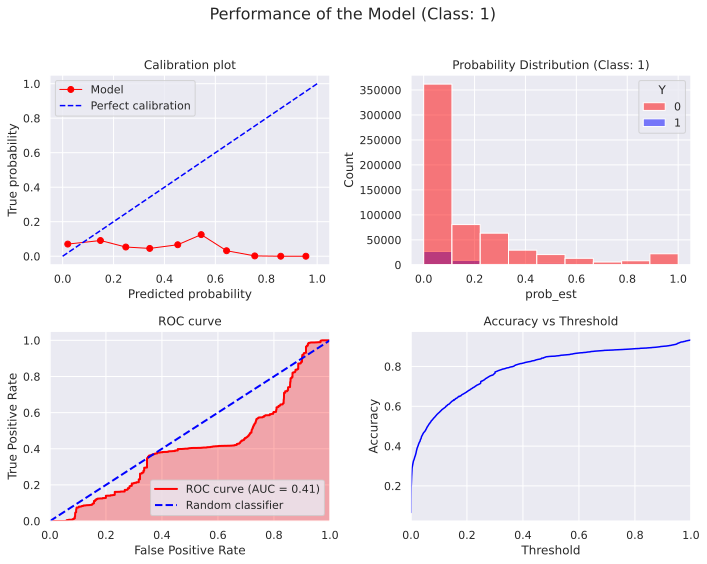

In [ ]:
plotClassPerformance(dfTS_eval['Y'], xgb_fit.predict_proba(X_test[INPUTS_XGB]), selClass=1)

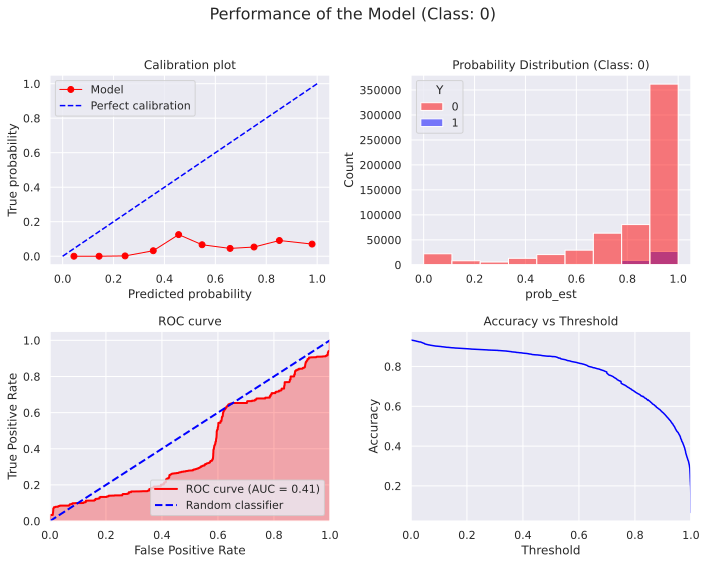

In [18]:
plotClassPerformance(dfTS_eval['Y'], xgb_fit.predict_proba(X_test[INPUTS_XGB]), selClass=0)

In [ ]:
•